In [1]:
import numpy as np
import networkx as nx
import utils as ut
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, noise
from keras.models import Model
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
#Stage 1 -  Random Surfing
def random_surf(cosine_sim_matrix, num_hops, alpha):
    
    num_nodes = len(cosine_sim_matrix)
    
    adj_matrix = ut.scale_sim_matrix(cosine_sim_matrix)
    P0 = np.eye(num_nodes, dtype='float32')
    P = np.eye(num_nodes, dtype='float32')
    A = np.zeros((num_nodes,num_nodes),dtype='float32')
    
    for i in range(num_hops):
        P = (alpha*np.dot(P,adj_matrix)) + ((1-alpha)*P0)
        A = A + P

    return A

In [3]:
#Stage 2 - PPMI Matrix
def PPMI_matrix(A):
    
    num_nodes = len(A)
    A = ut.scale_sim_matrix(A)
    
    row_sum = np.sum(A, axis=1).reshape(num_nodes,1)
    col_sum = np.sum(A, axis=0).reshape(1,num_nodes)
    
    D = np.sum(col_sum)
    PPMI = np.log(np.divide(np.multiply(D,A),np.dot(row_sum,col_sum)))
    #Gotta use numpy for division, else it runs into divide by zero error, now it'll store inf or -inf
    #All Diag elements will have either inf or -inf.
    #Get PPMI by making negative values to 0
    PPMI[np.isinf(PPMI)] = 0.0
    PPMI[np.isneginf(PPMI)] = 0.0
    PPMI[PPMI<0.0] = 0.0
    
    return PPMI

In [4]:
def sdae(PPMI, hidden_neurons, epochs=5):
    
    inp = Input(shape=(PPMI.shape[1],))
    enc = noise.GaussianNoise(0.2)(inp)
    
    for neurons in hidden_neurons:
        enc = Dense(neurons, activation = 'relu')(enc)
    
    dec = Dense(hidden_neurons[-2], activation = 'relu')(enc)
    for neurons in hidden_neurons[:-3][::-1]:
        dec = Dense(neurons, activation = 'relu')(dec)
    dec = Dense(PPMI.shape[1], activation='relu')(dec)
    
    auto_enc = Model(inputs=inp, outputs=dec)
    auto_enc.compile(optimizer='adam', loss='mse')
    
    auto_enc.fit(x=PPMI, y=PPMI, batch_size=10, epochs=epochs)
    
    encoder = Model(inputs=inp, outputs=enc)
    encoder.compile(optimizer='adam', loss='mse')
    embeddings = encoder.predict(PPMI)
    return embeddings

In [50]:
"""
- group can be  'NG3', 'NG6', 'NG9'
- Max hops for transition matrix - should be a positive natural number
- alpha is probability that random surfing will go to next vertex. (1-Alpha) is probability that it will return back to 
    original vertex and restart. Range 0-1
- hidden_neurons is the number of hidden neurons in each layer. Make sure there's 3 or more layers.
"""

group = 'NG9'
max_hops = 3
alpha = 0.98
hidden_neurons = [1800,1024,512,192]

text_corpus, file_names, target = ut.read_data(group)
cosine_sim_matrix = ut.get_cosine_sim_matrix(text_corpus)

A = random_surf(cosine_sim_matrix, max_hops, alpha)
PPMI = PPMI_matrix(A)

embeddings = sdae(PPMI, hidden_neurons, 20)

#Save embeddings

#Metrics
ut.compute_metrics(embeddings, target)


/home/grad24/dangpnh/miniconda3/envs/tsnecuda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/20
1800/1800 [==============================] - 3s 1ms/step - loss: 0.0108
Epoch 2/20
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0100
Epoch 3/20
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0098
Epoch 4/20
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0093
Epoch 5/20
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0091
Epoch 6/20
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0090
Epoch 7/20
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0089
Epoch 8/20
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0088
Epoch 9/20
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0086
Epoch 10/20
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0086
Epoch 11/20
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0084
Epoch 12/20
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0083
E

In [51]:
def visualize_TSNE(embeddings,target):
    tsne = TSNE(n_components=2)
    data = tsne.fit_transform(embeddings)
    print(data.shape)
#     data = embeddings
    #plt.figure(figsize=(12, 6))
    plt.title("TSNE visualization of the embeddings")
    plt.scatter(data[:,0],data[:,1],c=target)

    return

(1800, 2)


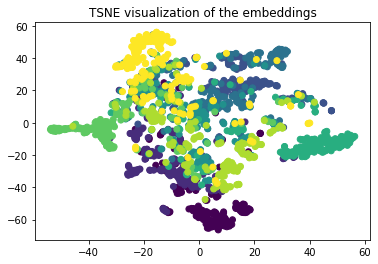

In [52]:
visualize_TSNE(embeddings, target)

## WOS

In [56]:
import pickle
import pandas as pd
import random
with open('data/mendeley/preprocessed_data.pkl', 'rb') as f: #data_test_all_50 data_test_[christian_gra_med]_150.pkl data_test_all  data_test_z5_N50.pkl reuters_vectorized_data_dang.pkl
    text_corpus = pickle.load(f)

df = pd.read_excel('data/mendeley/Data.xlsx')
train_label = list(df.Y)
## Pick half of mendeley
total_pick = int(len(train_label)/2)
index_list = list(range(len(train_label)))
# random item from list
sample_list_idx = random.choices(train_label, k=10000)

text_corpus = [text_corpus[i] for i in sample_list_idx]
train_label = [train_label[i] for i in sample_list_idx]
target = train_label

In [57]:


max_hops = 3
alpha = 0.98
hidden_neurons = [1800,1024,512,192]

# text_corpus, file_names, target = ut.read_data(group)
cosine_sim_matrix = ut.get_cosine_sim_matrix(text_corpus)

A = random_surf(cosine_sim_matrix, max_hops, alpha)
PPMI = PPMI_matrix(A)

embeddings = sdae(PPMI, hidden_neurons, 20)

#Save embeddings

#Metrics
ut.compute_metrics(embeddings, target)


/home/grad24/dangpnh/miniconda3/envs/tsnecuda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/20
10000/10000 [==============================] - 48s 5ms/step - loss: 0.0549
Epoch 2/20
10000/10000 [==============================] - 47s 5ms/step - loss: 0.0257
Epoch 3/20
10000/10000 [==============================] - 47s 5ms/step - loss: 0.0221
Epoch 4/20
10000/10000 [==============================] - 47s 5ms/step - loss: 0.0233
Epoch 5/20
10000/10000 [==============================] - 47s 5ms/step - loss: 0.0165
Epoch 6/20
10000/10000 [==============================] - 48s 5ms/step - loss: 0.0226
Epoch 7/20
10000/10000 [==============================] - 47s 5ms/step - loss: 0.0196
Epoch 8/20
10000/10000 [==============================] - 47s 5ms/step - loss: 0.0138
Epoch 9/20
10000/10000 [==============================] - 47s 5ms/step - loss: 0.0180
Epoch 10/20
10000/10000 [==============================] - 48s 5ms/step - loss: 0.0134
Epoch 11/20
10000/10000 [==============================] - 47s 5ms/step - loss: 0.0147
Epoch 12/20
10000/10000 [===========================

(10000, 2)


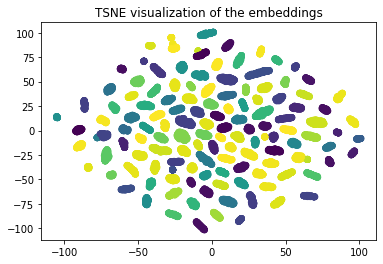

In [58]:
visualize_TSNE(embeddings, target)